In [2]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,ReLU,UpSampling2D,MaxPool2D,Dropout,BatchNormalization,Layer,Activation
from tensorflow.keras import Model,mixed_precision
from tensorflow.keras.activations import sigmoid,tanh,leaky_relu
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU,CategoricalCrossentropy
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt

# os.environ["KERAS_BACKEND"] = "tensorflow"
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["MLIR_CRASH_REPRODUCER_DIRECTORY"]="./crash"

import tensorflow as tf
print(tf.config.list_physical_devices())
tf.test.is_built_with_cuda()

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

['000000', '000001', '000002', '000003', '000004']
['dataset/images/im_000000.png', 'dataset/images/im_000001.png', 'dataset/images/im_000002.png']
['dataset/images/im_043165.png', 'dataset/images/im_007547.png', 'dataset/images/im_008390.png']
(128, 128, 6)
(128, 128)


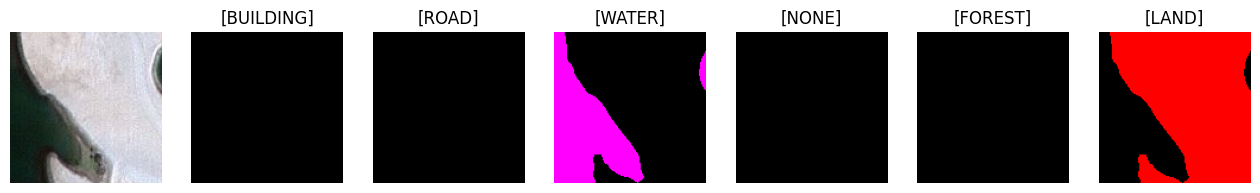

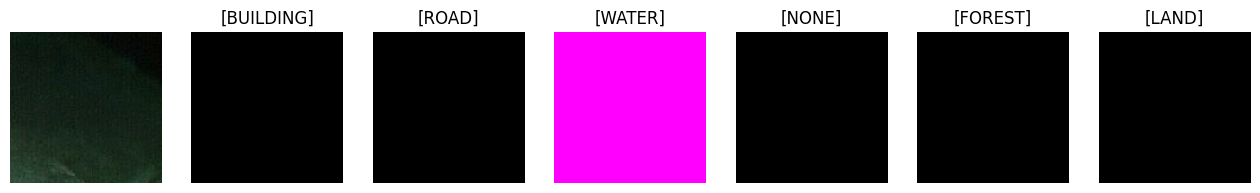

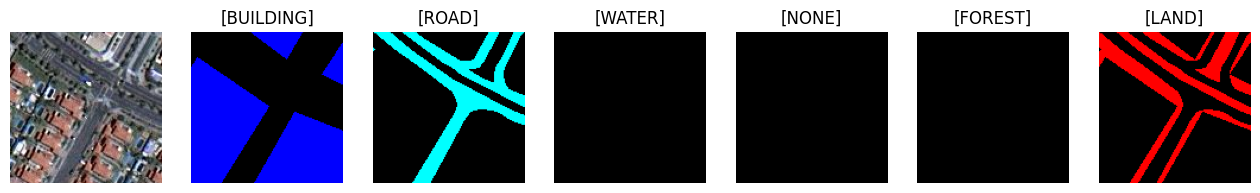

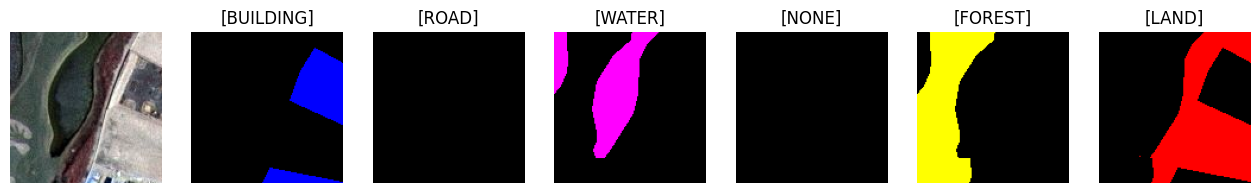

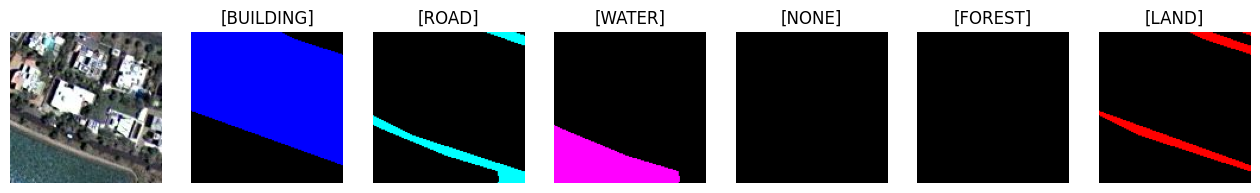

(128, 128, 6)
(128, 128)


2024-06-08 18:06:58.998306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


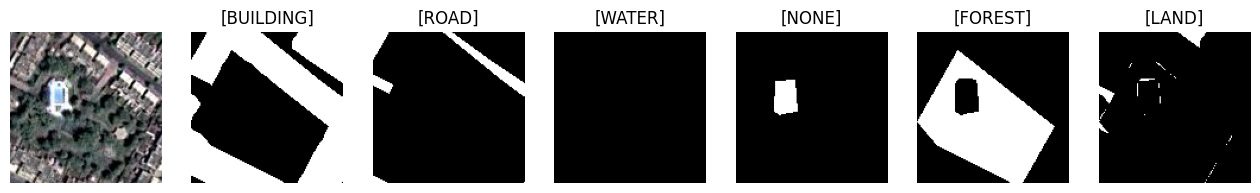

(128, 128, 6)
(128, 128)


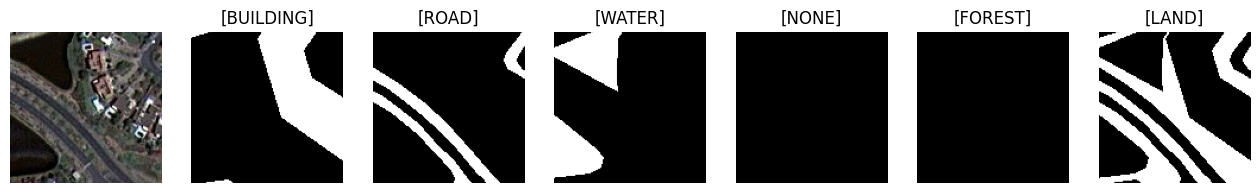

(128, 128, 6)
(128, 128)


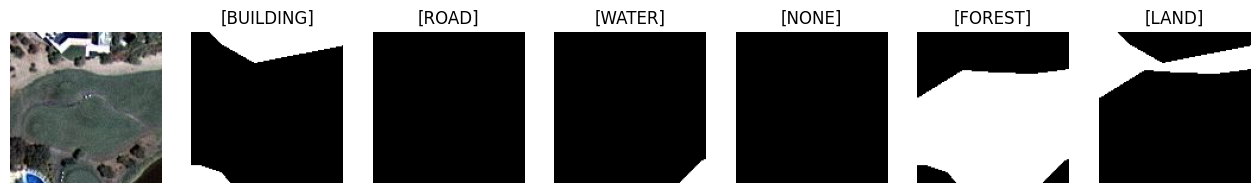

(128, 128, 6)
(128, 128)


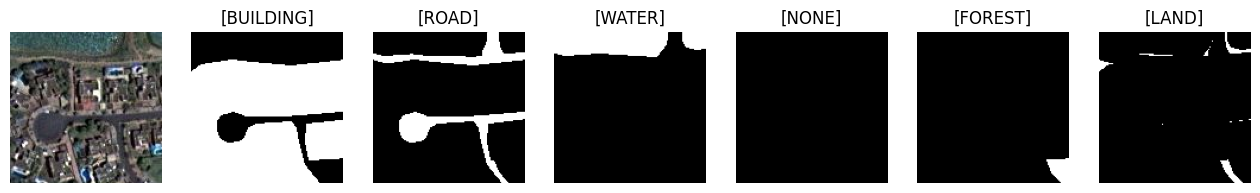

(128, 128, 6)
(128, 128)


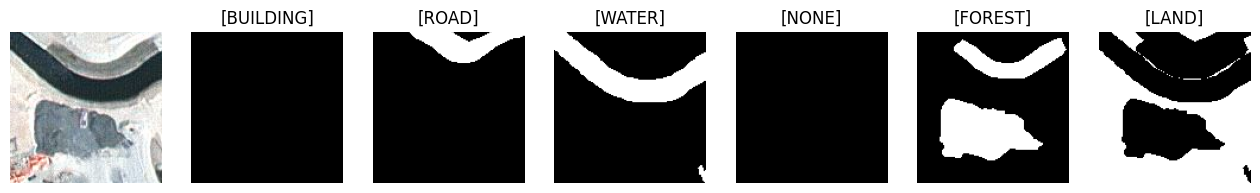

(128, 128, 6)
(128, 128)


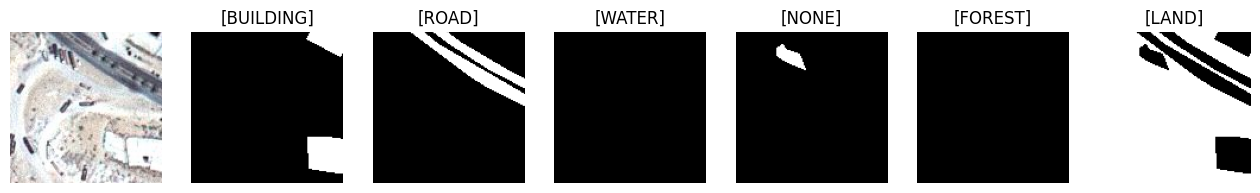

(128, 128, 6)
(128, 128)


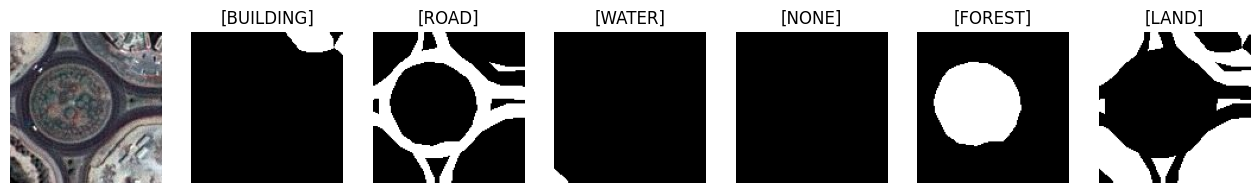

(128, 128, 6)
(128, 128)


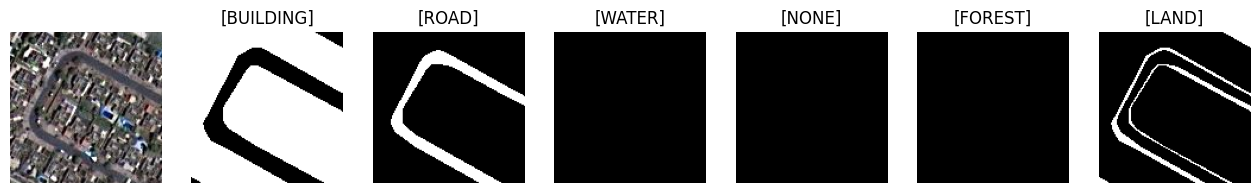

(128, 128, 6)
(128, 128)


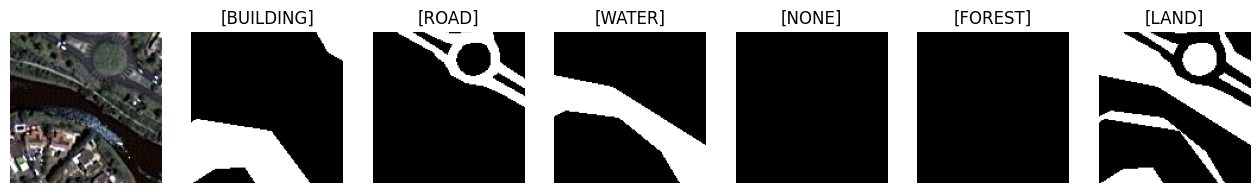

2024-06-08 18:07:00.423387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
from matplotlib import colors
import tensorflow as tf
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Directory where your images and masks are stored
images_dir = "dataset/images"
mask_directories = ["BUILDING", "ROAD", "WATER", "NONE", "FOREST", "LAND"]
modelname="unet-128-6ch-L-512-ACT-relu-LOSS-dice+rms-MET-acc+iou"



# List all image filenames
image_filenames = os.listdir(images_dir)
image_filenames = [i for i in image_filenames if i.endswith(('.png'))]
image_filenames.sort()
mask_filenames=[i.split("_")[1].split(".")[0] for i in image_filenames]
print(mask_filenames[:5])
image_filenames = [i for i in image_filenames if i.endswith(('.png'))]
tar_img=[
    '043165',
    '007547',
    '008390',
    '005571',
    '060565',
    '022764',
    '023448',
    '001343',
    '005403',
    ]
# tar_mask=[
#     '043165',
#     '007547',
#     '008390',
#     '005571',
#     '060565',
#     '022764',
#     '023448',
#     '001343',
#     '005403',
#     ]


# Create file paths for images
image_paths = [os.path.join(images_dir, filename) for filename in image_filenames]
print(image_paths[:3])
tar_im_paths = [os.path.join(images_dir, "im_"+filename+".png") for filename in tar_img]
print(tar_im_paths[:3])
# Split data into train and test set
image_train_dataset, image_test_dataset, mask_train, mask_test= train_test_split(image_paths,mask_filenames, train_size=0.9, test_size=0.1, shuffle=True)

# Create TensorFlow dataset for images
train_dataset = tf.data.Dataset.from_tensor_slices((image_train_dataset,mask_train))
test_dataset = tf.data.Dataset.from_tensor_slices((image_test_dataset,mask_test))
tar_dataset = tf.data.Dataset.from_tensor_slices((tar_im_paths,tar_img))


# Function to load image and corresponding masks
def load_image_and_masks(image_filename,mask_filename):
    # image_path = tf.io.matching_files( image_filename)
    # print(image_path)
    image = tf.io.read_file(image_filename)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    # print("Image",type(image))
    
    
    # mask_filenames = find_mask_filenames(image_filename)
    # masks = []
    masks=[]
    for mask_dir in mask_directories:
        r=f"./dataset/masks/{mask_dir}_BW/msk_"+mask_filename+".png"
        mask = tf.io.read_file(r)
        mask = tf.image.decode_image(mask, channels=1)  # Read mask as 1 channel
        mask = tf.cast(mask, tf.float32) / 255.0
        masks.append(mask)
    # masks.append(mask)
    masks=tf.concat(masks,axis=2)
    # Combine masks into a single multi-channel mask
    # combined_mask = tf.concat(masks, axis=-1)
    
    return image, masks, image_filename

# Map loading function to image dataset
train_dataset = train_dataset.map(load_image_and_masks)
test_dataset = test_dataset.map(load_image_and_masks)
tar_dataset=tar_dataset.map(load_image_and_masks)


# Set batch size
batch_size = 1000
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(64)
tar_dataset = tar_dataset.batch(1)

# Prefetch dataset for better performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


cmaps=[
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (0., 0., 1., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (0.,1, 1., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1, 0., 1., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (0., 1., 0., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1., 1., 0., 1.)]),
    colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1., 0., 0., 1.)]),
]

for images,masks, name in train_dataset.take(1):
    # Your training code here
    # for n-th whole masks
    print(masks[0].shape)
    # for n-th 1 layer mask
    print(masks[0][:,:,0].shape)
    for i in range(5):
        fig, (ax1,*am) = plt.subplots(1,7)
        fig.set_size_inches(16,8)
        ax1.imshow(images[i])
        ax1.axis("off")
        # ax1.set_title(f"Image {name[i]}")
        for k in range(0,6):
            am[k].imshow(masks[i,:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
            am[k].set_title(f"[{mask_directories[k]}]")
            am[k].axis("off")

        plt.show()
for images,masks,name in tar_dataset.take(len(tar_img)):
    # Your training code here
    # for n-th whole masks
    print(masks[0].shape)
    # for n-th 1 layer mask
    print(masks[0][:,:,0].shape)
    
    for i in range(1):
        fig, (ax1,*am) = plt.subplots(1,7)
        fig.set_size_inches(16,8)
        ax1.imshow(images[i])
        ax1.axis("off")
        # ax1.set_title(f"Image {name[i]}")
        for k in range(0,6):
            # am[k].imshow(masks[i,:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
            am[k].imshow(masks[i,:,:,k],cmap=colors.LinearSegmentedColormap.from_list(name='Trans2Blue', colors=[(0., 0., 0., 1.), (1., 1., 1., 1.)]),vmin=0.,vmax=1.)
            am[k].set_title(f"[{mask_directories[k]}]")
            am[k].axis("off")

        plt.show()

In [3]:
def create_upsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that upsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by an upsampling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        
        x = ReLU()(x)
        # somehow we try tanh
        # x = Activation(tanh)(x)
        # x = Activation(leaky_relu)(x)
        x = UpSampling2D(size=(2, 2))(x)
        return x
    return layer

def create_downsample_layer(filters, kernel_size, padding='same', kernel_initializer='he_normal'):
    """ This function creates a layer that downsamples an input tensor using a convolutional, batch
    normalization, and ReLU activation, followed by a max pooling operation. """
    def layer(x):
        x = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        # somehow we try tanh
        # x = Activation(tanh)(x)
        # x = Activation(leaky_relu)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        return x
    return layer



dropout_rate = 0.15

inputs = Input(shape=(128, 128, 3))

# # Encoder part of the DeepUNet
x = create_downsample_layer(64, 6, padding='same', kernel_initializer='he_normal')(inputs)
x = create_downsample_layer(128, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(256, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_downsample_layer(512, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
# x = create_downsample_layer(1024, 6, padding='same', kernel_initializer='he_normal')(x)
# x = Dropout(dropout_rate)(x)
# x = create_downsample_layer(2048, 3, padding='same', kernel_initializer='he_normal')(x)
# x = Dropout(dropout_rate)(x)

# # Decoder part of the DeepUNet
# x = create_upsample_layer(1024, 3, padding='same', kernel_initializer='he_normal')(x)
# x = Dropout(dropout_rate)(x)
# x = create_upsample_layer(512, 6, padding='same', kernel_initializer='he_normal')(x)
# x = Dropout(dropout_rate)(x)
x = create_upsample_layer(256, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(128, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(64, 6, padding='same', kernel_initializer='he_normal')(x)
x = Dropout(dropout_rate)(x)
x = create_upsample_layer(32, 6, padding='same', kernel_initializer='he_normal')(x)
outputs = Conv2D(6, 1, padding = 'same', activation='sigmoid')(x)


model = Model(inputs=inputs, outputs=outputs)
model.load_weights(f"models/{modelname}.keras")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 12,474,342 (47.59 MB)

 Trainable params: 12,471,462 (47.57 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [4]:
early_stop = EarlyStopping(monitor='val_mean_io_u', patience=90, verbose=1,
                           mode='max', restore_best_weights=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50,min_lr=1e-6,
#                               verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=90,min_lr=1e-6,
                              verbose=1, mode='min')

adam=Adam()

# filepath = "checkpoints/unet-128-6ch-{epoch:03d}-{loss:.4f}.keras"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

checkpoint = tf.train.Checkpoint(optimizer=adam, model=model)
manager = tf.train.CheckpointManager(
    checkpoint, directory=f"checkpoints/{modelname}/", max_to_keep=10)
status = checkpoint.restore(manager.latest_checkpoint)


training_cnt=0

In [5]:
import pandas as pd

# Sample DataFrame
metrics_file_name=f'metrics/{modelname}.csv'


try:
    metrics_df = pd.read_csv(metrics_file_name)
    print(metrics_df)
    training_cnt=metrics_df['epoch'].max() if not np.isnan(metrics_df['epoch'].max()) else 0
    max_iou=metrics_df['val_iou'].max() if not np.isnan(metrics_df['val_iou'].max()) else 0.0
    max_acc=metrics_df['val_acc'].max() if not np.isnan(metrics_df['val_acc'].max()) else 0.0
    min_loss=metrics_df['val_loss'].min() if not np.isnan(metrics_df['val_loss'].max()) else float('inf')
except:
    data = {'epoch': [],
    'val_acc': [],
    'val_loss': [],
    'val_iou': []}
    metrics_df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    metrics_df.to_csv(metrics_file_name, index=False)
    training_cnt=0
    max_iou=0.0
    max_acc=0.0
    min_loss=float('inf')
metrics_df = metrics_df.astype({"epoch": int})
data_template={'epoch': 0,
    'val_acc': 0.0,
    'val_loss': 0.0,
    'val_iou': 0.0}





      epoch   val_acc    val_loss   val_iou
0         1  0.490125  524.756653  0.491063
1         2  0.650230  498.175659  0.417204
2         3  0.604594  490.598328  0.470935
3         4  0.717051  443.034637  0.491897
4         5  0.354572  581.143494  0.426580
...     ...       ...         ...       ...
5096   5097  0.878589  166.632721  0.852771
5097   5098  0.877492  166.506653  0.847826
5098   5099  0.878134  164.164413  0.844074
5099   5100  0.861991  180.060410  0.806206
5100   5101  0.880958  164.183548  0.855760

[5101 rows x 4 columns]


In [6]:
print(status,manager)

<tensorflow.python.checkpoint.checkpoint.CheckpointLoadStatus object at 0x7e93dc70e7a0> <tensorflow.python.checkpoint.checkpoint_management.CheckpointManager object at 0x7e9574067d90>


In [7]:
def dice_loss(y_true, y_pred):
    # Flatten the predictions and ground truth

    y_true_flat = tf.reshape(y_true,  [-1, tf.reduce_prod(tf.shape(y_true)[2:])])

    # y_true_flat = tf.reshape(y_true,  [-1])
    y_pred_flat = tf.reshape(y_pred,  [-1, tf.reduce_prod(tf.shape(y_pred)[2:])])
    # y_pred_flat = tf.reshape(y_pred,  [-1])
    # print(y_true.shape)
    # print(y_true_flat.shape)

    # Compute the intersection and union
    
    # intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat,axis=[0])+1e-6
    # union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    union = tf.reduce_sum(y_true_flat,axis=[0]) + tf.reduce_sum(y_pred_flat,axis=[0])+1e-6
    

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union
    dice_loss=tf.reduce_sum(tf.math.abs(dice_loss))
    print(intersection,dice_loss)

    return dice_loss

def dice_loss_w_rms(y_true, y_pred):
    # Flatten the predictions and ground truth

    y_true_flat = tf.reshape(y_true,  [-1, tf.reduce_prod(tf.shape(y_true)[2:])])
    # y_true_flat = tf.reshape(y_true,  [-1])
    y_pred_flat = tf.reshape(y_pred,  [-1, tf.reduce_prod(tf.shape(y_pred)[2:])])
    # y_pred_flat = tf.reshape(y_pred,  [-1])
    # print(y_true.shape)
    # print(y_true_flat.shape)
    sq_dif=tf.square(y_true_flat-y_pred_flat)
    reduce_sq_dif=tf.reduce_mean(sq_dif)
    sqrt=tf.sqrt(reduce_sq_dif)

    # Compute the intersection and union
    
    # intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat,axis=[0])+1e-6
    # union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    union = tf.reduce_sum(y_true_flat,axis=[0]) + tf.reduce_sum(y_pred_flat,axis=[0])+1e-6
    

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union
    dice_loss=tf.reduce_sum(tf.math.abs(dice_loss))
    print(intersection,dice_loss)

    return dice_loss+sqrt
    # return sqrt


iou = MeanIoU(num_classes=6)  # One for all classes
# categorical_accuracy = CategoricalCrossentropy(from_logits=True)
# alpha = 0.7  # Weight for cross-entropy loss
# beta = 1 - alpha  # Weight for Dice loss
# dice_loss = losses.BinaryCrossentropy(from_logits=True)
# total_loss = alpha * losses.categorical_crossentropy(from_logits=True) + beta * dice_loss


# Compile the model with the Dice loss
# model.compile(loss=[dice_loss,dice_loss,dice_loss,dice_loss,dice_loss,dice_loss], optimizer='adam', metrics=['accuracy','accuracy','accuracy','accuracy','accuracy','accuracy'])
model.compile(loss=[dice_loss_w_rms], optimizer=adam, metrics=["accuracy",iou])

for a, b, name in test_dataset.take(1):
# test,t=test_dataset.take(1)
    print(type(a),len(b))
    im_test=a
    msk_test=b
    im_name=name
    print(msk_test[0].shape)
print(dice_loss(msk_test[2],msk_test[1]))
print(dice_loss_w_rms(msk_test[1],msk_test[2]))
# dice_loss(msk_test[0,:,:,0],msk_test[0,:,:,1])


<class 'tensorflow.python.framework.ops.EagerTensor'> 64
(128, 128, 6)
tf.Tensor([1.000e-06 1.606e+03 1.000e-06 1.000e-06 1.000e-06 3.783e+03], shape=(6,), dtype=float32) tf.Tensor(5.2074356, shape=(), dtype=float32)
tf.Tensor(5.2074356, shape=(), dtype=float32)
tf.Tensor([1.000e-06 1.606e+03 1.000e-06 1.000e-06 1.000e-06 3.783e+03], shape=(6,), dtype=float32) tf.Tensor(5.2074356, shape=(), dtype=float32)
tf.Tensor(5.6803985, shape=(), dtype=float32)


2024-05-28 22:05:17.100209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:

for a, b, name in test_dataset.take(1):
# test,t=test_dataset.take(1)
    print(type(a),len(b))
    im_test=a
    msk_test=b
    im_name=name

    

<class 'tensorflow.python.framework.ops.EagerTensor'> 64


2024-05-28 22:05:17.206609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
from random import randint,sample
import threading
from queue import Queue


num_epochs = 1
batch_size = 8
# Set seed
# tf.random.set_seed(42)
# tf.random.set_seed(1)



def process_history(history):
    global training_cnt
    global metrics_df
    for i in history.epoch:
        training_cnt+=1
        data_template['epoch']=training_cnt
        data_template['val_acc']=history.history['val_accuracy'][i]
        data_template['val_loss']=history.history['val_loss'][i]
        data_template['val_iou']=history.history['val_mean_io_u'][i]
        

        metrics_df=pd.concat([metrics_df, pd.DataFrame([data_template])], ignore_index=True)
    metrics_df.to_csv(metrics_file_name, index=False)

class LogWriter:
    def __init__(self):
        # self.log_file = log_file
        self.log_queue = Queue()
        self.thread = threading.Thread(target=self._write_logs)
        self.thread.daemon = True
        self.thread.start()

    def _write_logs(self):
        global metrics_df
        while True:
            hist = self.log_queue.get()
            if hist is None:  # Sentinel to stop the thread
                break
            # with open(self.log_file, 'a') as f:
            #     f.write(message + "\n")
            metrics_df=pd.concat([metrics_df, pd.DataFrame([hist])], ignore_index=True)
            metrics_df.to_csv(metrics_file_name, index=False)
            self.log_queue.task_done()

    def write_log(self, message):
        self.log_queue.put(message)

    def stop(self):
        self.log_queue.put(None)
        self.thread.join()

log_writer=LogWriter()


class save_if_better_cb(Callback):
    def on_epoch_end(self, epoch, logs=None):
        global max_iou,min_loss
        global training_cnt
        global metrics_df
        global manager
        global data_template
        global log_writer
        training_cnt+=1
        data_template['epoch']=training_cnt
        data_template['val_acc']=logs.get("val_accuracy")
        data_template['val_loss']=logs.get('val_loss')
        data_template['val_iou']=logs.get('val_mean_io_u')
        log_writer.write_log(data_template)
        # if logs.get('val_mean_io_u') > max_iou or logs.get('val_loss') < min_loss:
        #     max_iou=logs.get('val_mean_io_u')
        #     manager.save()
        #     print(f"\n\nEpoch {training_cnt} is better by {max_iou}, Saving the model...\n\n")
        #     model_path=f"models/{modelname}.keras"
        #     model.save(model_path)
            

        # metrics_df=pd.concat([metrics_df, pd.DataFrame([data_template])], ignore_index=True)
        # metrics_df.to_csv(metrics_file_name, index=False)

        # print("End epoch {} of training; got log keys: {}".format(epoch, keys))



def show_picture_compare(original, res, msk, name):
    global training_cnt
    main="""
        ........
        XXABCDEF
        XXGHIJKL
        ........
        """
    fig, am = plt.subplot_mosaic(main)
    fig.set_size_inches(16,8)
    plt.subplots_adjust(hspace=0.25)
    am["X"].set_title(f"Image {name.split('/')[-1]}")

    am["X"].imshow(original)    

    for k in range(0,6):
        am[chr(ord("A")+k)].imshow(msk[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        am[chr(ord("A")+k)].set_title(f"[{mask_directories[k]}]")
        am[chr(ord("G")+k)].imshow(res[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        # am[chr(ord("G")+k)].set_title(f"[Pred]")
        # plt.tight_layout()
    
    cmp_path=f'compare_img/{modelname}/{name.split("/")[-1].split(".")[0]}/'
    if not os.path.exists(cmp_path):
        os.makedirs(cmp_path)
    plt.savefig(f'{cmp_path}{training_cnt}.png',bbox_inches='tight')
    plt.close()
    # plt.show()

class write_im_perf(Callback):
    def on_epoch_end(self, epoch, logs=None):
        global max_iou,min_loss
        global training_cnt
        global metrics_df
        global manager
        global model
        global tar_dataset
        if training_cnt%5==0:
            for im,msk,im_name in tar_dataset.take(len(tar_img)):
                # print(im_test[idx].shape)
                
                ori=im[0]
                res=model.predict(ori[None,...])[0]
                msk=msk[0]
                name=im_name[0]
                name=str(name.numpy()).replace("'","")
                show_picture_compare(ori, res, msk, name)

        # print("End epoch {} of training; got log keys: {}".format(epoch, keys))

for images, masks, _ in train_dataset.take(70):

    # x,y=preprocess_images_and_masks(dataset_path,i*1000,1000)
    # train_images,train_masks,val_images,val_masks,test_images,test_masks=split(x,y)
    print(f"Take {training_cnt}")
    # training_cnt+=1
    # print(masks[0].shape)


    # Train the UNet model on the training data
    history = model.fit(#dataset,
                        images,
                        masks,
                        batch_size=batch_size, epochs=num_epochs,
                        # callbacks=[early_stop, reduce_lr],
                        callbacks=[early_stop,save_if_better_cb(),write_im_perf()],
                        validation_split=0.2,
                        verbose=1)
    manager.save()
    model_path=f"models/{modelname}.keras"
    model.save(model_path)
    epochs_list = list(range(1, len(history.history['val_loss']) + 1))
    val_loss = history.history['val_loss']
    val_accuracy_k = history.history.keys()

    # process_history(history)

    # Plot the epoch vs val_loss

    # Create a second y-axis for the val_accuracy
    # ax2 = ax1.twinx()
    # ax2.plot(epochs_list, val_loss, 'k-')
    # ax2.set_ylabel('Validation Loss', color='b')

    # Set the same scaling on the y-axes
    # ax1.set_ylim([0.0, 1])
    # ax2.set_ylim([0.0, 1])
    # idx_list=[randint(0,63) for _ in range(5)]
    
    # show im

    # idx_list=sample(range(0,63),5)
    # for idx in idx_list:
    #     # print(im_test[idx].shape)
        
    #     ori=im_test[idx]
    #     res=model.predict(ori[None,...])[0]
    #     msk=msk_test[idx]
    #     name=im_name[idx]
    #     name=str(name.numpy()).replace("'","")
    #     show_picture_compare(ori, res, msk, name)

Take 5101
Tensor("compile_loss/dice_loss_w_rms/add:0", shape=(768,), dtype=float32) Tensor("compile_loss/dice_loss_w_rms/Sum_3:0", shape=(), dtype=float32)
Tensor("compile_loss/dice_loss_w_rms/add:0", shape=(768,), dtype=float32) Tensor("compile_loss/dice_loss_w_rms/Sum_3:0", shape=(), dtype=float32)


I0000 00:00:1716905120.468175 1634613 service.cc:145] XLA service 0x7e938401f540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716905120.468196 1634613 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-28 22:05:20.874387: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-05-28 22:05:25.509805: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 1124073472 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 248774656/12613582848
2024-05-28 22:05:25.509857: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      1232928768
InUse:                       839111177
MaxInUse:                   1019472393
NumAllocs:                         934
MaxAllocSize:

  3/100 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9287 - loss: 122.6831 - mean_io_u: 0.9025  

I0000 00:00:1716905129.974561 1634613 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8977 - loss: 141.3170 - mean_io_u: 0.8511Tensor("compile_loss/dice_loss_w_rms/add:0", shape=(768,), dtype=float32) Tensor("compile_loss/dice_loss_w_rms/Sum_3:0", shape=(), dtype=float32)
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.8975 - loss: 141.5161 - mean_io_u: 0.8502 - val_accuracy: 0.9001 - val_loss: 159.2720 - val_mean_io_u: 0.8560
Restoring model weights from the end of the best epoch: 1.
Take 5102
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8864 - loss: 147.5904 - mean_io_u: 0.8354 - val_accuracy: 0.8872 - val_loss: 161.4901 - val_mean_io_u: 0.8591
Restoring model weights from the end of the best epoch: 1.
Take 5103
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8849 - loss: 142.5401 - mean_io_u: 0.8354 - val_accuracy: 0.8897 - val_loss: 167.8102 - val_mean_io_u: 0.8577
Restoring model weights from the end of the best epoch: 1.
Take 5104
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/steptep - accurac

2024-05-28 22:05:55.613313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Take 5105
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8907 - loss: 144.4686 - mean_io_u: 0.8455 - val_accuracy: 0.9090 - val_loss: 163.1959 - val_mean_io_u: 0.8808
Restoring model weights from the end of the best epoch: 1.
Take 5106
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8923 - loss: 145.2503 - mean_io_u: 0.8413 - val_accuracy: 0.8954 - val_loss: 147.2422 - val_mean_io_u: 0.8670
Restoring model weights from the end of the best epoch: 1.
Take 5107
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8878 - loss: 148.8098 - mean_io_u: 0.8416 - val_accuracy: 0.8895 - val_loss: 153.5995 - val_mean_io_u: 0.8514
Restoring model weights from the end of the best epoch: 1.
Take 5108
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8833 - loss: 141.3056 - mean_io_u: 0.8402 - val_accuracy: 0.8917 - val_loss: 158.5033 - val_mean_io_u: 0.8602
Restoring model weights from the end of the best epoch: 1.
Take 5109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepstep - accura

2024-05-28 22:06:25.004474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Take 5110
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9014 - loss: 142.3523 - mean_io_u: 0.8528 - val_accuracy: 0.8811 - val_loss: 167.3472 - val_mean_io_u: 0.8579
Restoring model weights from the end of the best epoch: 1.
Take 5111
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8819 - loss: 142.1788 - mean_io_u: 0.8376 - val_accuracy: 0.9068 - val_loss: 135.9915 - val_mean_io_u: 0.8783
Restoring model weights from the end of the best epoch: 1.
Take 5112
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8933 - loss: 140.1107 - mean_io_u: 0.8463 - val_accuracy: 0.9128 - val_loss: 133.0970 - val_mean_io_u: 0.8885
Restoring model weights from the end of the best epoch: 1.
Take 5113
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8875 - loss: 144.3181 - mean_io_u: 0.8407 - val_accuracy: 0.9040 - val_loss: 145.5748 - val_mean_io_u: 0.8717
Restoring model weights from the end of the best epoch: 1.
Take 5114
 21/100 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accura

In [ ]:
history.epoch
name.numpy()

In [ ]:
idx_list=[randint(0,63) for _ in range(10)]
for idx in idx_list:
    print(im_test[idx].shape)
    ori=im_test[idx]
    msk=msk_test[idx]
    main="""
    ........
    XXABCDEF
    XXGHIJKL
    ........
    """
    fig, am = plt.subplot_mosaic(main)
    fig.set_size_inches(16,8)
    # fig.set_constrained_layout(True)
    
    # print(msk.shape)
    # for n-th 1 layer mask
    # print(msk)
    res=r=model.predict(ori[None,...])[0]
    am["X"].imshow(im_test[idx])    

    for k in range(0,6):
        am[chr(ord("A")+k)].imshow(msk[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        am[chr(ord("A")+k)].set_title(f"True Mask[{k}]")
        am[chr(ord("G")+k)].imshow(res[:,:,k],cmap=cmaps[k],vmin=0.,vmax=1.)
        am[chr(ord("G")+k)].set_title(f"Pred Mask[{k}]")
    # plt.tight_layout()
    plt.show()

In [ ]:
fig,(ix1,ix2,ix3,ix4,ix5,ix6,ix7)=plt.subplots(1,7)
ix1.imshow(im_test[0])

res=r=model.predict(im_test[None,...][0])
ix2.imshow(msk_test[0][0])
ix3.imshow(msk_test[1][0])
ix4.imshow(msk_test[2][0])
# print(res)
ix5.imshow(res[0][0])
ix6.imshow(res[1][0])
ix7.imshow(res[2][0])
plt.show()

val_loss = history.history['val_loss']
val_accuracy_k = history.history.keys()


# Plot the epoch vs val_loss
ax1 = plt.subplot(111)
for _ in val_accuracy_k:
    if _=='val_loss':
        ax2 = ax1.twinx()
        val_loss = history.history[_]
        ax2.plot(epochs_list, val_loss, 'k-')
        ax2.set_ylabel('Validation Loss', color='b')
    else:

        ax1.plot(epochs_list, history.history[_], 'r-')
    # ax1.set_ylabel('Validation Accuracy', color='r')
ax1.set_ylim([0.0, 1])
ax2.set_ylim([0.0, 10])

# Create a second y-axis for the val_accuracy
# ax2 = ax1.twinx()
# ax2.plot(epochs_list, val_loss, 'k-')
# ax2.set_ylabel('Validation Loss', color='b')

In [ ]:

weights_path=f"weights/{modelname}.weights.h5"
model.save_weights(weights_path)

model_path=f"models/{modelname}.keras"
model.save(model_path)
print(model_path)


In [ ]:
model_json_path="models/unet-128-single-model-6ch.json"
model.to_json()
